In [56]:
import sys
from contextlib import closing
from six import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np
from collections import defaultdict

In [57]:
MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]


In [58]:

class TaxiEnv(discrete.DiscreteEnv):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations: 
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
        
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    Rewards: 
    There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render.modes': ['human', 'ansi']}

In [59]:
  def __init__(self):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0,0), (0,4), (4,0), (4,3)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1 # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else: # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else: # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

In [60]:
    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

In [61]:
   def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

In [62]:
    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else: outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

In [63]:
>>> import gym
env_test = gym.make('Taxi-v3')
env = gym.wrappers.Monitor(env_test, "C:/Users/Owner/Documents/MMAI/Reinf Learning/Taxi-Qlearning",  force=True)
observation = env.reset()
env.close()
env_test.close()
>>> n_state = env.observation_space.n
>>> print(n_state)

500


In [64]:
>>> n_action = env.action_space.n
>>> print(n_action)

6


In [65]:
>>> env.reset()

273

In [66]:
>>> env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [67]:
##Let's now go and pick up the passenger by heading west for three tiles and north for two tiles##
##(you can adjust this according to your initial state) and then executing the pick-up. Then, we render the environment again##
print(env.step(3))
print(env.step(3))
print(env.step(3))
print(env.step(1))
print(env.step(1))
print(env.step(4))


(253, -1, False, {'prob': 1.0})
(233, -1, False, {'prob': 1.0})
(213, -1, False, {'prob': 1.0})
(113, -1, False, {'prob': 1.0})
(13, -1, False, {'prob': 1.0})
(13, -10, False, {'prob': 1.0})


In [68]:
>>> env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


In [69]:
##Now, we go to the destination by heading south for four tiles (you can adjust this to your initial state) and then executing the drop-off:

In [70]:
>>> print(env.step(0))
>>> print(env.step(0))
>>> print(env.step(0))
>>> print(env.step(0))
>>> print(env.step(5))

(113, -1, False, {'prob': 1.0})
(213, -1, False, {'prob': 1.0})
(313, -1, False, {'prob': 1.0})
(413, -1, False, {'prob': 1.0})
(413, -10, False, {'prob': 1.0})


In [71]:
>>> env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [72]:
>>> import torch

## start defining the epsilon-greedy policy. ##

In [73]:
>>> def gen_epsilon_greedy_policy(n_action, epsilon):
        def policy_function(state, Q):
            probs = torch.ones(n_action) * epsilon / n_action
            best_action = torch.argmax(Q[state]).item()
            probs[best_action] += 1.0 - epsilon
            action = torch.multinomial(probs, 1).item()
            return action
        return policy_function

##Now, we specify the number of episodes and initialize two variables used to track the length and total reward for each episode##

In [74]:
>>> n_episode = 2000
>>> length_episode = [0] * n_episode
>>> total_reward_episode = [0] * n_episode

## Now, define the function that performs Q-learning:##

In [75]:
>>> def q_learning(env, gamma, n_episode, alpha):
        n_action = env.action_space.n
        Q = defaultdict(lambda: torch.zeros(n_action))
        for episode in range(n_episode):
            state = env.reset()
            is_done = False
            while not is_done:
                action = epsilon_greedy_policy(state, Q)
                next_state, reward, is_done, info = env.step(action)
                td_delta = reward + gamma * torch.max(Q[next_state])- Q[state][action]
                Q[state][action] += alpha * td_delta
                if is_done:
                    break
                state = next_state
                policy = {}
        for state, actions in Q.items():
            policy[state] = torch.argmax(actions).item()
        return Q, policy

In [76]:
>>> def q_learning(env, gamma, n_episode, alpha):
        n_action = env.action_space.n
        Q = defaultdict(lambda: torch.zeros(n_action))
        for episode in range(n_episode):
            state = env.reset()
            is_done = False
            while not is_done:
                action = epsilon_greedy_policy(state, Q)
                next_state, reward, is_done, info = env.step(action)
                td_delta = reward + gamma * torch.max(Q[next_state])- Q[state][action]
                Q[state][action] += alpha * td_delta
                length_episode[episode] += 1
                total_reward_episode[episode] += reward
                if is_done:
                    break
                state = next_state
        policy = {}
        for state, actions in Q.items():
                policy[state] = torch.argmax(actions).item()
        return Q, policy

In [77]:
>>> gamma = 1
>>> alpha = 0.4
>>> epsilon = 0.1
>>> epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

In [78]:
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha)

In [79]:
>>> print('The optimal policy:\n', optimal_policy)

The optimal policy:
 {447: 1, 427: 2, 347: 1, 327: 1, 227: 2, 127: 0, 107: 0, 27: 0, 7: 0, 207: 2, 247: 1, 147: 1, 167: 1, 47: 2, 67: 2, 267: 1, 287: 1, 367: 2, 387: 1, 487: 1, 467: 1, 307: 1, 187: 1, 87: 4, 99: 0, 426: 1, 446: 1, 326: 2, 346: 1, 226: 2, 206: 2, 246: 2, 266: 1, 166: 1, 146: 2, 186: 1, 66: 2, 46: 2, 86: 4, 98: 0, 126: 0, 106: 0, 26: 0, 6: 0, 306: 1, 286: 1, 366: 2, 386: 1, 486: 1, 466: 2, 183: 3, 163: 0, 143: 0, 83: 3, 63: 0, 43: 2, 283: 3, 263: 3, 243: 3, 223: 1, 203: 1, 103: 1, 123: 3, 23: 3, 3: 4, 19: 0, 383: 3, 363: 1, 343: 1, 323: 1, 303: 1, 39: 0, 119: 0, 139: 0, 239: 2, 219: 2, 259: 2, 403: 1, 128: 0, 108: 0, 28: 0, 8: 0, 228: 3, 208: 0, 248: 3, 148: 0, 48: 0, 68: 2, 168: 0, 308: 0, 408: 4, 416: 1, 328: 1, 348: 3, 448: 1, 428: 1, 316: 1, 216: 1, 236: 1, 116: 1, 136: 1, 16: 5, 0: 5, 78: 0, 58: 0, 198: 3, 298: 3, 278: 3, 258: 3, 238: 3, 218: 0, 158: 0, 178: 0, 398: 3, 378: 1, 358: 3, 338: 1, 138: 3, 118: 0, 38: 3, 18: 0, 2: 4, 22: 3, 122: 1, 102: 1, 498: 3, 478: 1,

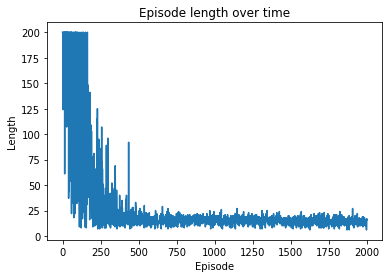

In [80]:
>>> import matplotlib.pyplot as plt
>>> plt.plot(length_episode)
>>> plt.title('Episode length over time')
>>> plt.xlabel('Episode')
>>> plt.ylabel('Length')
>>> plt.show()

In [81]:
print(length_episode)

[200, 200, 200, 124, 200, 200, 200, 200, 200, 200, 135, 200, 136, 200, 61, 200, 200, 200, 174, 200, 200, 200, 200, 200, 159, 200, 200, 107, 200, 200, 184, 200, 151, 200, 200, 200, 113, 199, 200, 200, 37, 117, 44, 105, 132, 200, 200, 171, 200, 124, 54, 101, 158, 200, 62, 192, 200, 200, 123, 22, 200, 32, 101, 200, 116, 174, 77, 138, 54, 137, 83, 110, 200, 200, 170, 18, 108, 157, 84, 151, 200, 103, 22, 95, 200, 172, 200, 154, 90, 164, 200, 200, 200, 105, 32, 45, 72, 200, 200, 34, 66, 64, 114, 92, 93, 159, 94, 83, 200, 35, 39, 9, 150, 33, 167, 16, 117, 162, 21, 12, 122, 200, 8, 34, 118, 102, 31, 93, 86, 131, 82, 17, 28, 200, 58, 63, 54, 128, 200, 76, 88, 40, 80, 23, 181, 154, 9, 26, 114, 40, 14, 200, 122, 31, 83, 76, 8, 23, 49, 70, 51, 83, 31, 200, 109, 110, 38, 128, 147, 148, 98, 62, 89, 47, 38, 117, 78, 93, 16, 18, 106, 141, 39, 30, 50, 88, 55, 109, 73, 26, 103, 58, 57, 55, 78, 17, 36, 22, 75, 9, 26, 32, 17, 71, 27, 35, 10, 81, 28, 57, 24, 33, 10, 50, 51, 27, 11, 11, 31, 24, 66, 64, 21, 

In [82]:
import numpy as np

from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

In [83]:
Y=np.array(length_episode)

In [84]:
p = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="linear", x_axis_location="above",
           background_fill_color="#efefef", x_range=(50,150))

In [85]:
p.line(range(0, 2000),Y)
p.yaxis.axis_label = 'Length'

In [86]:
select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="linear", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

In [87]:
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

In [88]:
select.line(range(0, 2000),Y)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

In [89]:
show(column(p, select))

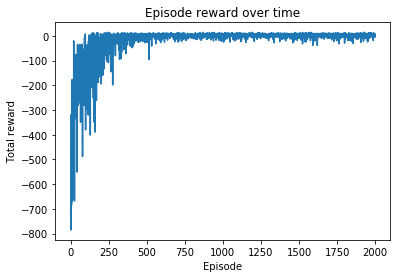

In [38]:
>>> plt.plot(total_reward_episode)
>>> plt.title('Episode reward over time')
>>> plt.xlabel('Episode')
>>> plt.ylabel('Total reward')
>>> plt.show()

In [39]:
print(total_reward_episode)

[-704, -677, -695, -785, -317, -686, -677, -425, -470, -177, -668, -497, -587, -264, -389, -243, -254, -272, -659, -650, -20, -416, -263, -295, -308, -668, -326, -299, -335, -150, -189, -263, -78, -272, -227, -75, -272, -263, -184, -317, -263, -254, -551, -263, -209, -34, -117, -38, -227, -281, -263, -147, -142, -104, -227, -218, -218, -83, -159, -214, -34, -245, -171, -272, -236, -349, -254, -176, -227, -139, -272, -50, -263, -153, -82, -33, -76, -236, -488, -90, -138, -224, -54, -230, -272, -61, -236, -67, -281, -166, -56, -7, -65, -139, -68, -70, 8, -236, -380, -180, -72, -123, -54, -173, -176, -36, -38, -56, -86, -83, -144, -299, -203, -226, -115, -315, -320, -21, -228, -12, 4, -174, -60, -312, -48, -166, -52, -114, -37, -401, -35, -199, -13, 4, -113, -104, -111, 7, -209, -167, -86, 9, -158, -109, -39, 13, -97, -129, -211, -252, -17, -84, -214, -348, -72, -3, 10, -42, -93, -82, -122, -389, 2, -34, -153, -142, -176, -89, -98, -261, -149, -31, 11, -77, -111, 14, -164, 0, 12, 2, -189,

In [40]:
Y1=np.array(total_reward_episode)

In [41]:
p2 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="linear", x_axis_location="above",
           background_fill_color="#efefef", x_range=(50,150))

In [42]:
p2.line(range(0, 2000),Y1)
p2.yaxis.axis_label = 'Total reward'

In [43]:
select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p2.y_range,
                x_axis_type="linear", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

In [44]:
range_tool = RangeTool(x_range=p2.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

In [45]:
select.line(range(0, 2000),Y1)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

In [46]:
show(column(p2, select))

##Bonus Track##

In [47]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show

In [48]:
TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

In [49]:
p3 = figure(title="Episode length over time", tools=TOOLS)

In [50]:

##p3.circle(range(0, 500), Y, legend_label="")
p3.line(range(0, 2000), Y, legend_label="")

GlyphRenderer(id='1484', ...)

In [51]:
p3.legend.title = ''

In [52]:
p4 = figure(title="Episode reward over time", tools=TOOLS)

In [53]:
##p4.circle(range(0, 500),Y1, legend_label="",color="orange")
p4.line(range(0, 2000),Y1, legend_label="",color="orange")

GlyphRenderer(id='1534', ...)

In [54]:
p4.legend.title = ''

In [55]:
output_file("lenght.html", title="Episode length over time")

show(gridplot([p3,p4], ncols=2, plot_width=400, plot_height=400))  # open a browser